In [3]:
1+1

2

In [ ]:
include("src/gravlens.jl")

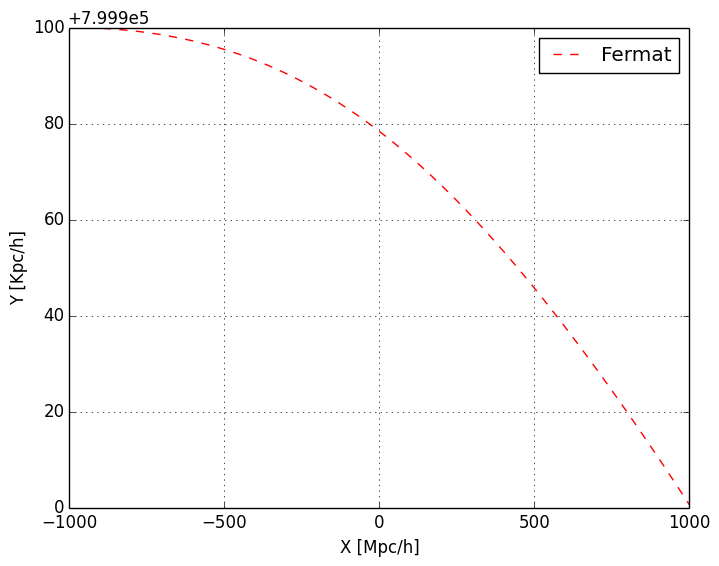

  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
in show at /Users/ariel/.julia/v0.5/PyPlot/src/PyPlot.jl


PyObject <matplotlib.text.Text object at 0x3211ceb90>

  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/ariel/.julia/v0.5/IJulia/src/kernel.jl:35


In [5]:
const _x=-1.0e6
const _y=8.0e5
const _rs = sqrt(_x*_x+_y*_y)
const _Θ = abs(asin(_y/_rs));
const _ϕm = π-_Θ
const _tgα = 0.0;

function MXI(r)
    volume = 4/3*π*r.^3
    r = r/1000.0/h # from [Kpc/h] to [Mpc]
    sigma = 10.^(-1.6*log10(r)+2.3)
    return volume*sigma*ρ0(0.0)
end
function PXI(r)
    quadgk(r->-G*MXI(r)./r./r,_rs,r)[1]
end
function _phi_4(x,y)
    y += _y
    r = sqrt(x*x+y*y)
    #G*MXI(r)/r
    PXI(r)
end
function _force_4(x,y)
    y += _y
    const r = sqrt(x*x+y*y)
    const gmr3 = G*MXI(r)/r/r/r
    gmr3*x, gmr3*y
end

fx, fy = fermat(_phi_4, _force_4, abs(_x), _tgα, 100000; abstol=1e-23, reltol=1e-23);
fy+=_y;

hold(false)
plot(to_small(fx)/1e3,to_small(fy),"--r", label="Fermat")
grid(true)
legend(loc=1)
xlabel("X [Mpc/h]")
ylabel("Y [Kpc/h]")

In [6]:
const s = Spline1D(fx./1000.0,fy-_y, k=5);
const dy_lens_lss = evaluate(s, 0.0)

-21.632430381141603

In [7]:
N=100000;
z = 0.5;
mvir = 200.0;
concentration = 30.0;
rvir = RVIR(z, mvir);
rscale = rvir/concentration;

rs = 1.0e6;
b_up = 3.0;
b_down=4.0;
Θ = 0.0;
tgα_up = b_up/rs;
tgα_down = b_down/rs;
ϕm_up = π+atan(tgα_up)/4;

function phi(x,y)
    r = sqrt(x*x+y*y)
    tnfw_potential(mvir, rscale, r, rvir);
end
function force(x,y)
    const r = sqrt(x*x+y*y)
    const gmr3 = G*tnfw_m(mvir, rscale, r, rvir)/r/r/r
    gmr3*x, gmr3*y
end

function phi_lss(x,y)
    y_l1 = y-dy_lens_lss
    r = sqrt(x*x+y_l1*y_l1)
    p1 = tnfw_potential(mvir, rscale, r, rvir);
    y_l2 = y+_y
    r = sqrt(x*x+y_l2*y_l2)
    #p2 = G*MXI(r)/r
    p2 = PXI(r)
    p1+p2
end
function force_lss(x,y)
    y_l1 = y-dy_lens_lss
    r = sqrt(x*x+y_l1*y_l1)
    gmr3 = G*tnfw_m(mvir, rscale, r, rvir)/r/r/r
    fx1 = gmr3*x
    fy1 = gmr3*y_l1
    y_l2 = y+_y
    r = sqrt(x*x+y_l2*y_l2)
    gmr3 = G*MXI(r)/r/r/r
    fx2 = gmr3*x
    fy2 = gmr3*y_l2
    fx1+fx2, fy1+fy2
end

fx_up, fy_up = fermat(phi, force, rs, tgα_up, N; abstol=1e-15, reltol=1e-15, ext=1.3);
fx_down, fy_down = fermat(phi, force, rs, tgα_down, N; abstol=1e-15, reltol=1e-15, ext=1.3);

lx_up, ly_up = fermat(phi_lss, force_lss, rs, tgα_up, N; abstol=1e-15, reltol=1e-15, ext=1.3);
lx_down, ly_down = fermat(phi_lss, force_lss, rs, -tgα_down, N; abstol=1e-15, reltol=1e-15, ext=1.3);


#ny_down = -ny_down
#ty_down = -ty_down
fy_down = -fy_down

fx_up,fy_up, fx_down,fy_down = extrapolate_to_meeting_same_side(fx_up,fy_up, fx_down,fy_down);
lx_up,ly_up, lx_down,ly_down = extrapolate_to_meeting_same_side(lx_up,ly_up, lx_down,ly_down);

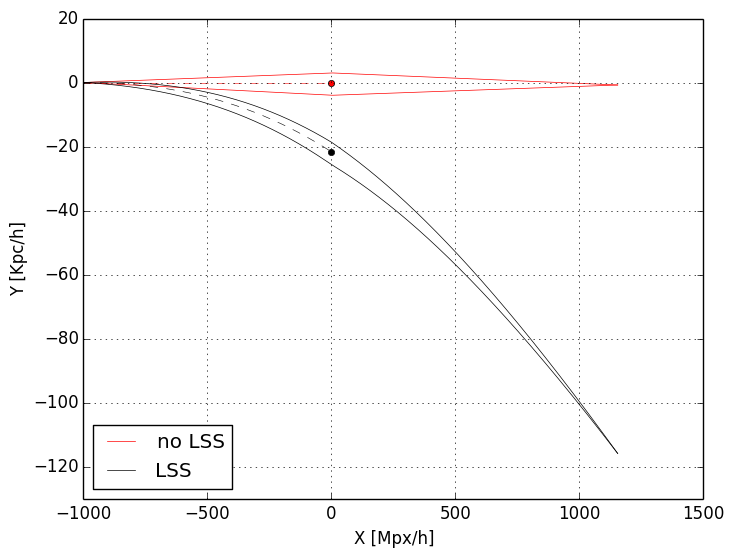

(-130,20)

In [8]:
hold(false)
plot(fx_up/1e3,fy_up,"-r", label="no LSS", ms=0.01, lw=0.5)
hold(true)
plot(fx_down/1e3,fy_down,"-r", ms=0.01, lw=0.5)

plot(lx_up/1e3,ly_up,"-k", label="LSS", ms=0.01, lw=0.5)
plot(lx_down/1e3,ly_down,"-k", ms=0.01, lw=0.5)

plot(0,0,"or",ms=5.0)
plot(0,dy_lens_lss,"ok",ms=5.0)

plot([-1000000.0,0.0]/1e3,[0.0,0.0],"--r", lw=0.4)
ixs=find(fx.<0.0)
plot(fx[ixs]/1e3,fy[ixs]-_y,"--k", lw=0.4)

grid(true)

legend(loc=3)
xlabel("X [Mpx/h]")
ylabel("Y [Kpc/h]")
ylim(-130,20)

#xlim(745,748)
#ylim(-76,-71)

In [9]:
dt = abs(time(phi, fx_up, fy_up) - time(phi, fx_down,fy_down))

2.7832847138142824e-11

In [10]:
abs(dt)*9.8e8*365*24

238.93942611152852

In [11]:
dt_lss = abs(time(phi_lss, lx_up, ly_up) - time(phi_lss, lx_down,ly_down))

2.7852387063376227e-11

In [12]:
abs(dt_lss)*9.8e8*365*24

239.10717246167223